# Neuer Datensatz
Data from https://www.kaggle.com/datasets/jeanmidev/smart-meters-in-london

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import mchmm as mc

## Load files

In [2]:
filename1 = "data/london_hourly/block_10.csv"
filename2 = "data/london_hourly/block_11.csv"
filename3 = "data/london_hourly/block_12.csv"
names = [filename1, filename2, filename3]

frame_types = dict(zip(['LCLid', 'tstp', 'energy(kWh/hh)'], [str, object, np.floating]))
kwargs = {
    'dtype': frame_types,
    'na_values': {'Null'}
}
dataframes = (pd.read_csv(name, **kwargs) for name in names)
data = pd.concat(dataframes, ignore_index=True)
data.fillna(0);
data['energy(kWh/hh)'] = data['energy(kWh/hh)'].replace(np.nan, 0)

# create a list from each energy meter
values = data.groupby('LCLid')['energy(kWh/hh)'].apply(list)
timepoints = data.groupby('LCLid')['tstp'].apply(list)

In [3]:
# start um 12 a clock
start_index = []
for timepoint in timepoints:
    for i in range(len(timepoint)):
        if timepoint[i][11:16] == '12:00':
            start_index.append(i)
            break
new_values = [values[i][start_index[i]:] for i in range(len(values))]
new_timepoints = [timepoints[i][start_index[i]:] for i in range(len(timepoints))]

# remove meters that have less then 25000 entries
min_length = 25000
new_values_with_certain_length = [new_values[i] for i in range(len(new_values)) if len(new_values[i]) > min_length]
new_timepoints_with_certain_length = [new_timepoints[i] for i in range(len(new_timepoints)) if len(new_timepoints[i]) > min_length]

# convert to float
new_values_float = list(map(lambda x: list(map(float, x)), new_values_with_certain_length))
# sum over all meaters at the same timepoint
summed_values_float = np.array([sum(new_values_float[i][k] for i in range(len(new_values_float))) for k in range(min_length)])

# scale list
max_v = 20
max_summed_values = max(summed_values_float)
summed_values_scaled = np.array([max_v * summed_values_float[i]/ max_summed_values for i in range(len(summed_values_float))])

# convert to int
summed_values_scaled_int =  summed_values_scaled.astype(int)

## Initialize markov chain

In [4]:
chain = mc.MarkovChain().from_data(summed_values_scaled_int)

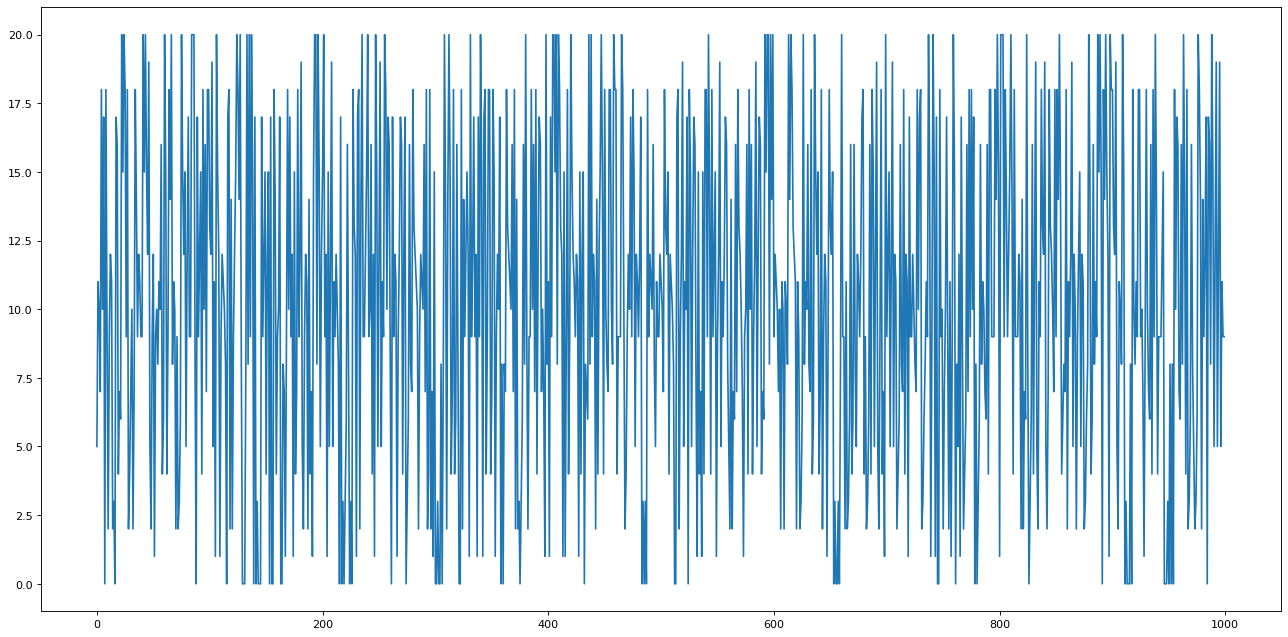

In [43]:
fig = plt.figure(figsize=(20, 10), dpi=80)
plt.plot(chain.simulate(n=1000, start=5, ret="states"))